In [1]:
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

# LOADING DATASET
snp_df = pd.read_csv('sp500_stocks.zip')

# DISPLAYING COUNT AND FIRST FEW ROWS
print('TOTAL DATA ROW COUNT: ', len(snp_df), '\n')
snp_df.head()

TOTAL DATA ROW COUNT:  1830417 



,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,46.422302,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,46.131523,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,46.785759,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,46.819294,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,47.149204,70.501671,70.501671,69.648827,69.974915,4073337.0


In [2]:
# FILTERING FOR DATA SPECIFIC TO CITIBANK (Symbol=='C')
c_df = snp_df[snp_df['Symbol']=='C']
print('CITIBANK DATA ROW COUNT: ', len(c_df), '\n')
c_df.head()

CITIBANK DATA ROW COUNT:  3639 



,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
407568,2010-01-04,C,26.409620,34.000000,34.099998,33.400002,33.599998,40679350.0
407569,2010-01-05,C,27.419401,35.299999,35.500000,34.099998,34.200001,66861710.0
407570,2010-01-06,C,28.273827,36.400002,36.799999,35.099998,35.599998,67433890.0
407571,2010-01-07,C,28.351513,36.500000,37.000000,36.099998,36.900002,67245190.0
407572,2010-01-08,C,27.885462,35.900002,36.700001,35.099998,36.500000,62409770.0


### Understanding the data
- SORT BY DATE: day-ahead price prediction of stocks are contingent upon stock price arranged by date
- ADD PREVIOUS DAY VALUES: 

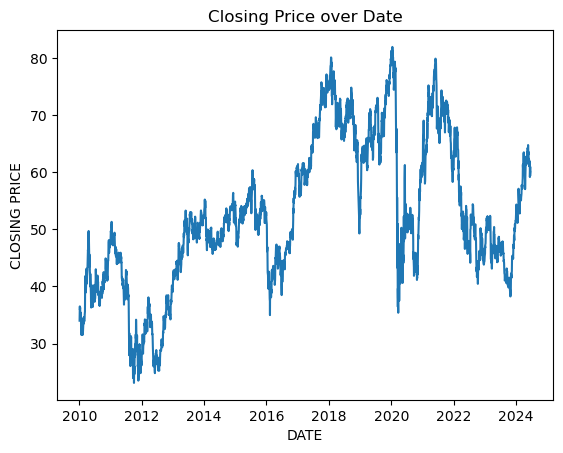

In [3]:
# ENSURE DATA IS ORDERED BY DATE
c_df.sort_values('Date')

# REMOVE EMPTY DATA
c_df = c_df.dropna()

# PLOT TO UNDERSTAND VARIATION IN PRICE OVER TIME 
date = c_df['Date']
close = c_df['Close']
plt.plot(pd.to_datetime(date), close, label='')
plt.xlabel('DATE')
plt.ylabel('CLOSING PRICE')
plt.title('Closing Price over Date')
plt.show()

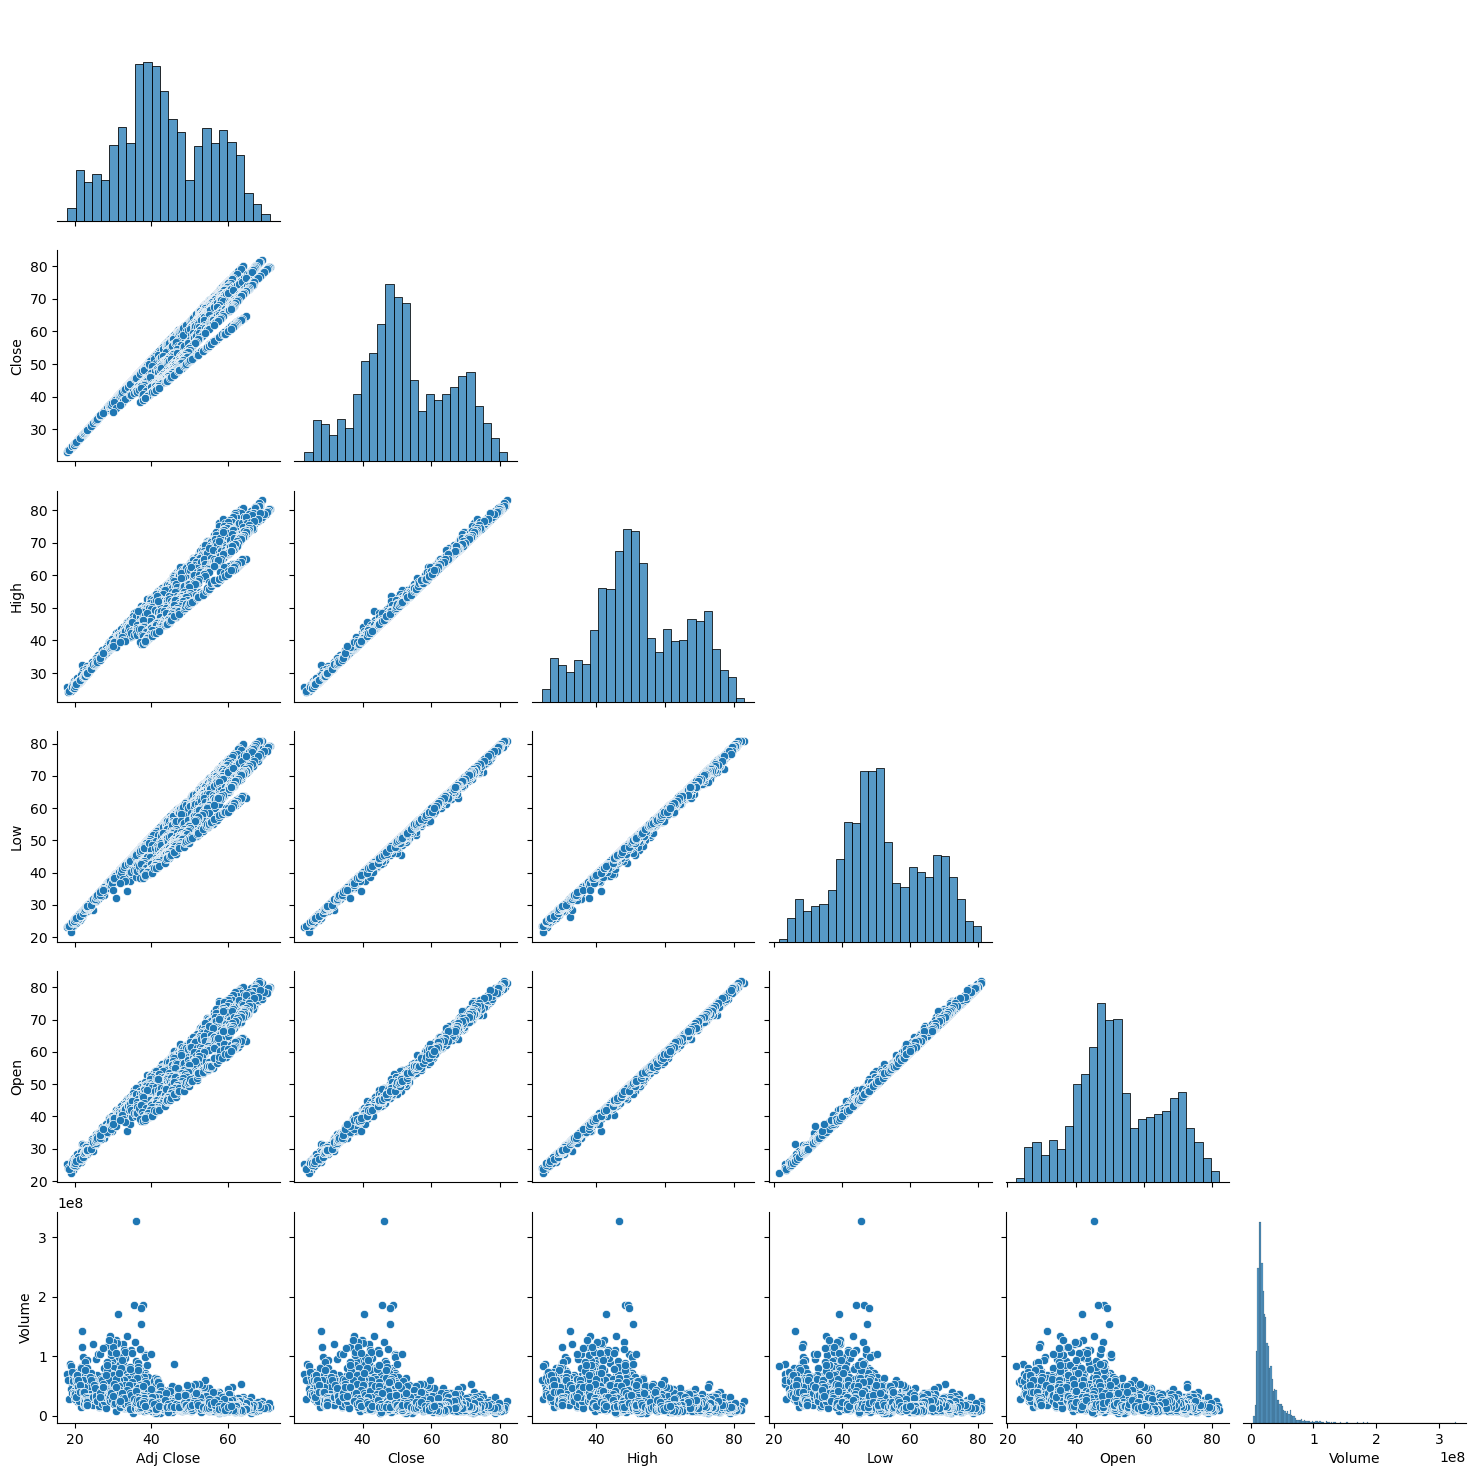

In [4]:
# PAIRPLOT TO HELP FEATURE SELECTION
sb.pairplot(c_df, corner=True)

- Above pairplot displays how stock `volume` has negligible effect on the `price`
- We will neglect 'Volume' in our prediction model

In [5]:
# REARRANGING DATA FOR PREVIOUS DAY DATA
c_df['Close_prev'] = c_df.Close.shift(1)
c_df['High_prev'] = c_df.High.shift(1)
c_df['Low_prev'] = c_df.Low.shift(1)
c_df['Open_prev'] = c_df.Open.shift(1)

# REMOVE EMPTY DATA
c_df = c_df.dropna(subset=["Close_prev"])

# CORRELATION TO HELP FEATURE SELECTION
c_df.corr(numeric_only=True)

,Adj Close,Close,High,Low,Open,Volume,Close_prev,High_prev,Low_prev,Open_prev
Adj Close,1.000000,0.959701,0.959815,0.957883,0.957841,-0.508084,0.956857,0.957051,0.955214,0.955114
Close,0.959701,1.000000,0.999065,0.999168,0.998177,-0.486550,0.996830,0.995991,0.996192,0.995130
High,0.959815,0.999065,1.000000,0.998752,0.999217,-0.475627,0.997992,0.997464,0.996961,0.996278
Low,0.957883,0.999168,0.998752,1.000000,0.998997,-0.494986,0.997666,0.996349,0.997197,0.995674
Open,0.957841,0.998177,0.999217,0.998997,1.000000,-0.482444,0.998689,0.997842,0.997879,0.996820
Volume,-0.508084,-0.486550,-0.475627,-0.494986,-0.482444,1.000000,-0.483773,-0.476153,-0.489003,-0.480452
Close_prev,0.956857,0.996830,0.997992,0.997666,0.998689,-0.483773,1.000000,0.999065,0.999168,0.998178
High_prev,0.957051,0.995991,0.997464,0.996349,0.997842,-0.476153,0.999065,1.000000,0.998752,0.999218
Low_prev,0.955214,0.996192,0.996961,0.997197,0.997879,-0.489003,0.999168,0.998752,1.000000,0.998998
Open_prev,0.955114,0.995130,0.996278,0.995674,0.996820,-0.480452,0.998178,0.999218,0.998998,1.000000


- Day-ahead closing price has an excellent correlation to the previous days Close, High, Low, Open in that order, and the values are 0.996830, 0.995991, 0.996192, and 0.995130 respectively
- Column `Volume` shows to have a negetive correlation, considering the fact `Volume` has major swings when the `Close Price` is near alltime high or low

In [6]:
c_df = c_df[['Date','Close','Close_prev','High_prev','Low_prev','Open_prev']]

# CHOOSING TARGET AND FEATURES
features = ['Close_prev', 'High_prev', 'Low_prev', 'Open_prev']
target = 'Close'
X = c_df[features]
y = c_df[target]

# SPLITTING THE DATASET INTO TEST AND TRAIN DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [7]:
# Creating linear regresion model
model = LinearRegression()
# Training the model
model.fit(X_train, y_train)

X = sm.add_constant(X_train) 
sr_model = sm.OLS(y_train, X).fit()
print(sr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.072e+05
Date:                Tue, 25 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:13:47   Log-Likelihood:                -3917.4
No. Observations:                2728   AIC:                             7845.
Df Residuals:                    2723   BIC:                             7874.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2134      0.086      2.469      0.0

- Per the P-value we can conclude that the model is significant
- From the Coeffs revious day `Close_Prev` value is a significant feature to predict the next day `Close`
- Followed by the `Open_Prev`, `Low_Prev` and finally the `High_Prev`
- Since R-squared is very close to 1.0, this model has extremely low room for improvement

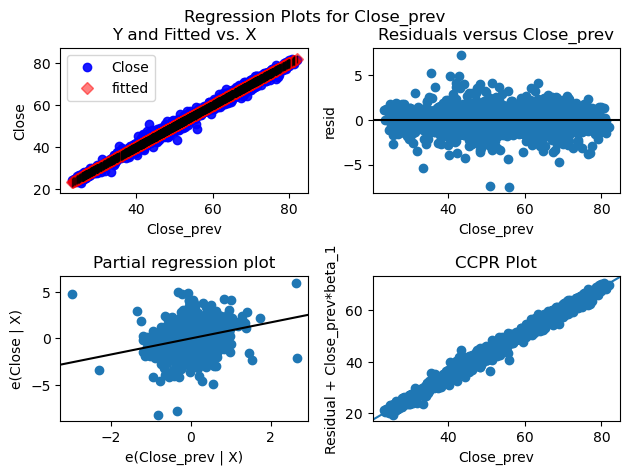

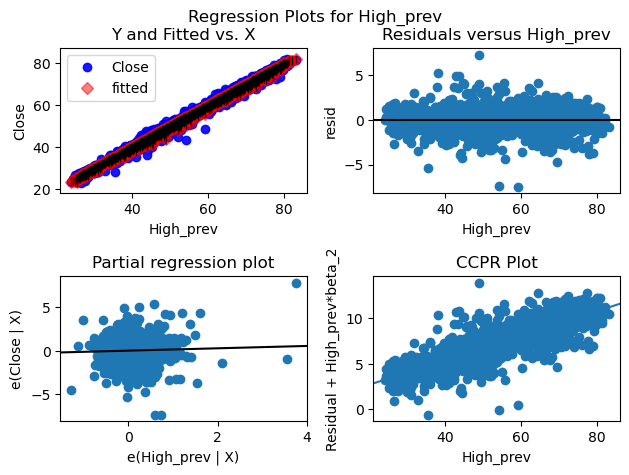

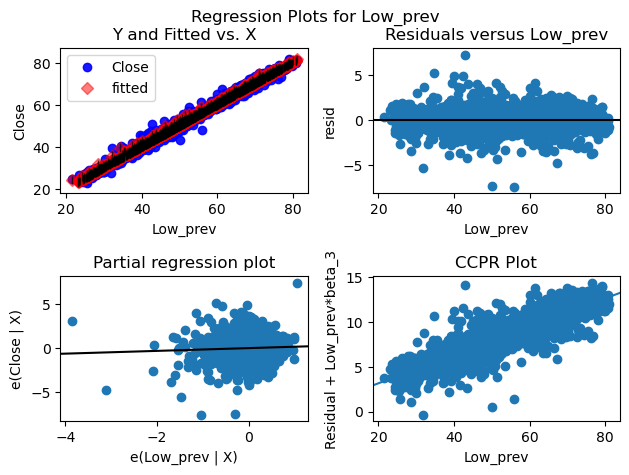

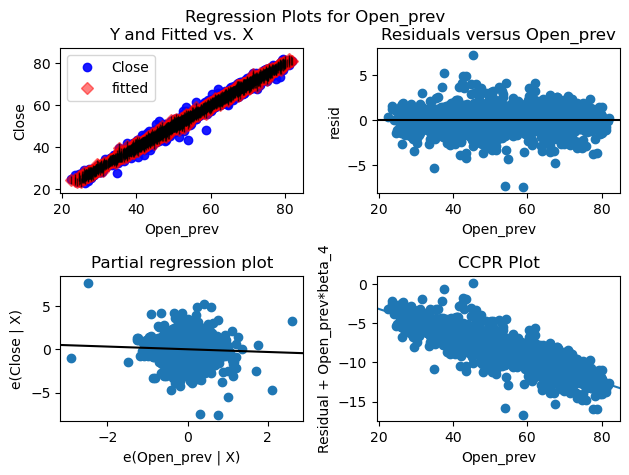

In [8]:
sm.graphics.plot_regress_exog(sr_model, 'Close_prev')
sm.graphics.plot_regress_exog(sr_model, 'High_prev')
sm.graphics.plot_regress_exog(sr_model, 'Low_prev')
sm.graphics.plot_regress_exog(sr_model, 'Open_prev')
plt.show()

- From the plots is can be concluded that there are not as many outliers and hence Mean Absolute Error (MAE) make more sense than Root Mean Squared Error (RMSE)

In [9]:
# PREDICTING WITH THE TEST DATA
y_pred = model.predict(X_test)
error = (y_pred-y_test)
y_pct = ((y_pred-y_test)/y_test)*100
result = pd.DataFrame({"ACTUAL PRICE": y_pred, "PREDICTED PRICE": y_test, "ERROR": error, "PCT DIFFERENCE": y_pct})
display(result)

# EVALUATING PREDICTIONS
print(f'MAE : {MAE(y_test, y_pred)}')
print(f'MSE : {MSE(y_test, y_pred) ** (1/2)}')
print(f'R2 : {R2(y_test, y_pred)}')


,ACTUAL PRICE,PREDICTED PRICE,ERROR,PCT DIFFERENCE
409824,54.014752,52.820000,1.194752,2.261931
408135,36.958134,36.369999,0.588135,1.617089
408550,53.375355,53.009998,0.365356,0.689222
408578,54.158153,54.810001,-0.651848,-1.189287
410041,73.087700,72.970001,0.117699,0.161298
...,...,...,...,...
408165,27.905633,26.920000,0.985633,3.661341
409568,75.783416,76.150002,-0.366585,-0.481399
407804,46.363242,46.900002,-0.536759,-1.144476
408296,35.827163,36.029999,-0.202836,-0.562964


MAE : 0.6962104172141436
MSE : 1.025342790493932
R2 : 0.9936932049014792


### CONCLUSION
- The model seems to effectively predict day-ahead `close price` for the `CITIBANK` stock
- One must acknowledge that the stock close price does not vary by a lot in the short-term, there is not enough data to account for the outliers
- Accounting for features with `long-term` impact on stock price can help predict weekly, monthly and yearly `close price`